In [1]:

import time

import cv2
import numpy as np
import tensorflow as tf
from PIL import Image

from centernet import CenterNet

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

mode = "predict"
crop            = False
count           = False
heatmap_save_path = "model_data/heatmap_vision.png"

centernet = CenterNet(heatmap = True if mode == "heatmap" else False)


2022-12-01 03:32:44.635668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 03:32:44.642443: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


model_data/centernet_resnet50_voc.h5 model, anchors, and classes loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path |     model_data/centernet_resnet50_voc.h5|
|             classes_path |               model_data/voc_classes.txt|
|              input_shape |                               [512, 512]|
|                 backbone |                                 resnet50|
|               confidence |                                      0.3|
|                  nms_iou |                                      0.3|
|                      nms |                                     True|
|          letterbox_image |                                    False|
|                  heatmap |                                    False|
-----------------------------------------------------------

In [2]:
first_conv_layer = centernet.centernet.layers[2]
print(first_conv_layer)
print(first_conv_layer.weights)

[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
array([[[[ 1.94906741e-02, -2.80679278e-02,  7.65900407e-03, ...,
          -3.17537785e-02, -6.02737814e-02,  8.70463904e-03],
         [ 1.21029643e-02,  5.93803227e-02, -1.80919785e-02, ...,
          -3.90131362e-02,  2.31730919e-02,  1.54836066e-02],
         [ 2.25866819e-03, -5.08528687e-02, -2.90570073e-02, ...,
          -4.17485125e-02,  3.10440157e-02,  1.07532786e-02]],

        [[ 4.51345323e-03, -1.77525692e-02,  4.83121519e-04, ...,
          -1.80582870e-02, -1.72566436e-03,  1.92807689e-02],
         [ 1.55303208e-02,  7.53806159e-02, -1.63652170e-02, ...,
          -1.70739833e-02,  1.23554608e-02, -1.44846104e-02],
         [ 1.26479780e-02, -2.67485082e-02, -2.78822277e-02, ...,
          -1.99206714e-02, -2.04527173e-02, -5.49067045e-03]],

        [[ 2.00270489e-02, -2.21067891e-02,  9.86857060e-03, ...,
          -6.01443136e-03,  5.16742328e-03,  5.63815935e-03],
         [ 4.24814709e-02, 

In [3]:
layer_name_to_index = dict()
for index, layer in enumerate(centernet.centernet.layers):
    layer_name_to_index[layer.name] = index
print(layer_name_to_index)

{'input_1': 0, 'zero_padding2d': 1, 'conv1': 2, 'bn_conv1': 3, 'activation': 4, 'max_pooling2d': 5, 'res2a_branch2a': 6, 'bn2a_branch2a': 7, 'activation_1': 8, 'res2a_branch2b': 9, 'bn2a_branch2b': 10, 'activation_2': 11, 'res2a_branch2c': 12, 'res2a_branch1': 13, 'bn2a_branch2c': 14, 'bn2a_branch1': 15, 'add': 16, 'activation_3': 17, 'res2b_branch2a': 18, 'bn2b_branch2a': 19, 'activation_4': 20, 'res2b_branch2b': 21, 'bn2b_branch2b': 22, 'activation_5': 23, 'res2b_branch2c': 24, 'bn2b_branch2c': 25, 'add_1': 26, 'activation_6': 27, 'res2c_branch2a': 28, 'bn2c_branch2a': 29, 'activation_7': 30, 'res2c_branch2b': 31, 'bn2c_branch2b': 32, 'activation_8': 33, 'res2c_branch2c': 34, 'bn2c_branch2c': 35, 'add_2': 36, 'activation_9': 37, 'res3a_branch2a': 38, 'bn3a_branch2a': 39, 'activation_10': 40, 'res3a_branch2b': 41, 'bn3a_branch2b': 42, 'activation_11': 43, 'res3a_branch2c': 44, 'res3a_branch1': 45, 'bn3a_branch2c': 46, 'bn3a_branch1': 47, 'add_3': 48, 'activation_12': 49, 'res3b_branch

In [4]:
centernet.centernet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [5]:
import tensorflow as tf
from nets.resnet import ResNet50


input_shape = [512, 512, 3]
num_classes = 20
image_input = tf.keras.layers.Input(shape=input_shape)
x = ResNet50(image_input)
x = tf.keras.layers.Dropout(rate=0.5)(x)
# -------------------------------#
#   解码器
# -------------------------------#
num_filters = 256
# 16, 16, 2048  ->  32, 32, 256 -> 64, 64, 128 -> 128, 128, 64
for i in range(3):
    # 进行上采样
    x = tf.keras.layers.Conv2DTranspose(
        num_filters // pow(2, i), (4, 4), strides=2, use_bias=False, padding="same"
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
# 最终获得128,128,64的特征层
# hm header
y1 = tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
y1 = tf.keras.layers.BatchNormalization()(y1)
y1 = tf.keras.layers.Activation("relu")(y1)
y1 = tf.keras.layers.Conv2D(
    num_classes,
    1,
    activation="sigmoid",
)(y1)

my_model = tf.keras.Model(inputs=image_input, outputs=y1)
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 518, 518, 3)  0          ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 64  9408        ['zero_padding2d_1[0][0]']       
                                )                                                           

In [6]:
print(len(my_model.layers))
print(my_model.layers[2].weights)

188
[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
array([[[[-3.65509093e-02,  4.37299861e-03,  5.06504588e-02, ...,
          -5.81168570e-03, -1.76757686e-02,  6.13281911e-04],
         [-6.81475722e-05, -2.09394097e-02,  4.82543744e-03, ...,
          -3.40567045e-02, -1.49001786e-02,  2.44909991e-03],
         [ 3.85591164e-02,  3.33881602e-02,  1.79067887e-02, ...,
           1.32496841e-02,  5.55529213e-03,  3.94273549e-02]],

        [[ 2.59480812e-02, -1.06351906e-02,  6.60870550e-03, ...,
          -1.28037138e-02,  1.74994059e-02,  1.91292372e-02],
         [-5.35711199e-02, -3.14124078e-02, -5.86059084e-03, ...,
           2.07747575e-02,  1.85408145e-02, -9.46121663e-03],
         [-4.09401488e-03,  2.04736199e-02,  3.73987928e-02, ...,
          -5.90190990e-03, -2.90519111e-02,  1.13866478e-03]],

        [[-2.16019284e-02, -7.80423963e-03,  9.92473122e-03, ...,
           2.55402587e-02, -1.05864312e-02, -2.00568475e-02],
         [-5.42106340e-

In [7]:
for centernet_layer, my_layer in zip(centernet.centernet.layers[:184], my_model.layers[:184]):
    my_layer.set_weights(centernet_layer.get_weights())
my_model.layers[184].set_weights(centernet.centernet.layers[184].get_weights())
my_model.layers[185].set_weights(centernet.centernet.layers[187].get_weights())
my_model.layers[186].set_weights(centernet.centernet.layers[190].get_weights())
my_model.layers[187].set_weights(centernet.centernet.layers[193].get_weights())

In [8]:
print(my_model.layers[2].weights)

[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
array([[[[ 1.94906741e-02, -2.80679278e-02,  7.65900407e-03, ...,
          -3.17537785e-02, -6.02737814e-02,  8.70463904e-03],
         [ 1.21029643e-02,  5.93803227e-02, -1.80919785e-02, ...,
          -3.90131362e-02,  2.31730919e-02,  1.54836066e-02],
         [ 2.25866819e-03, -5.08528687e-02, -2.90570073e-02, ...,
          -4.17485125e-02,  3.10440157e-02,  1.07532786e-02]],

        [[ 4.51345323e-03, -1.77525692e-02,  4.83121519e-04, ...,
          -1.80582870e-02, -1.72566436e-03,  1.92807689e-02],
         [ 1.55303208e-02,  7.53806159e-02, -1.63652170e-02, ...,
          -1.70739833e-02,  1.23554608e-02, -1.44846104e-02],
         [ 1.26479780e-02, -2.67485082e-02, -2.78822277e-02, ...,
          -1.99206714e-02, -2.04527173e-02, -5.49067045e-03]],

        [[ 2.00270489e-02, -2.21067891e-02,  9.86857060e-03, ...,
          -6.01443136e-03,  5.16742328e-03,  5.63815935e-03],
         [ 4.24814709e-02, 

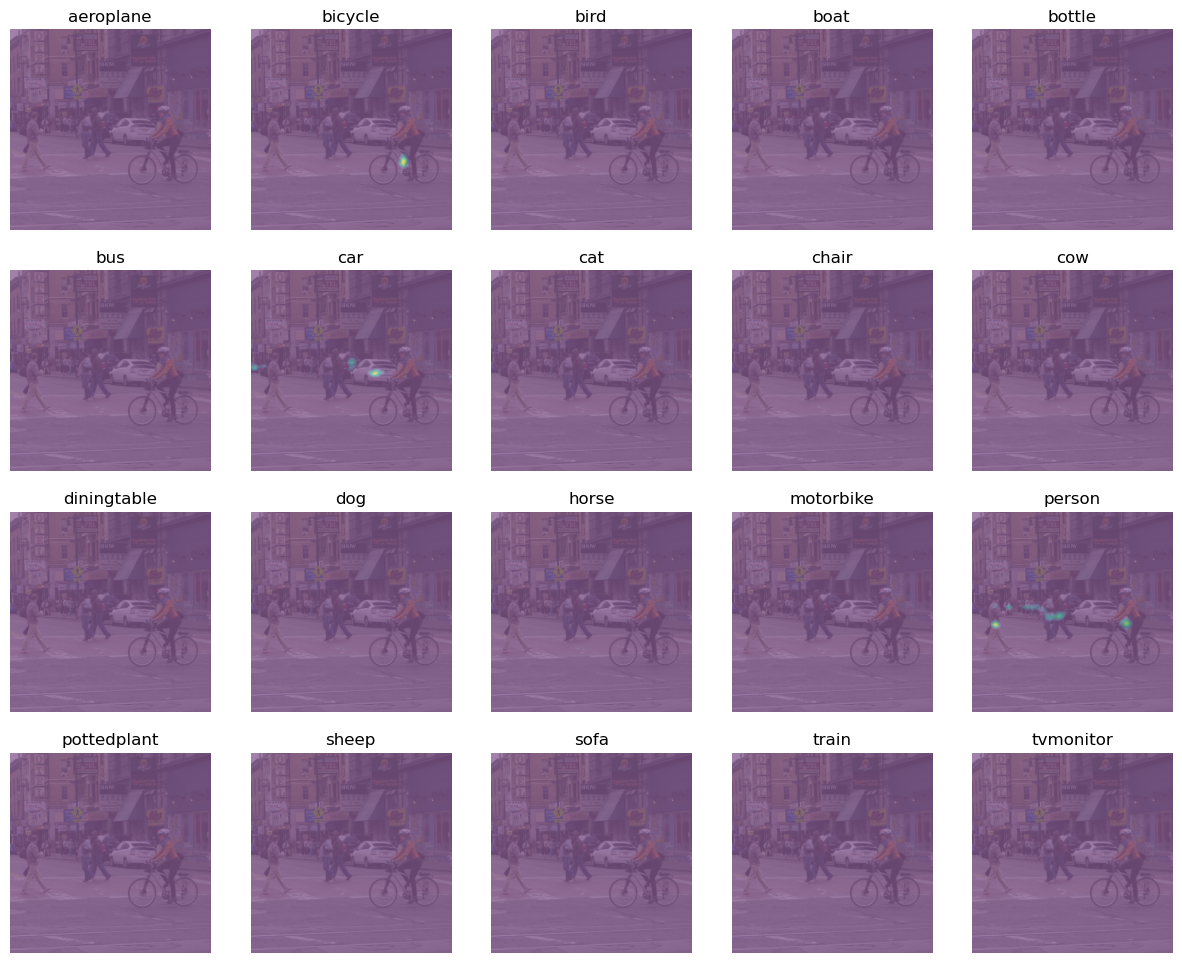

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import cvtColor, resize_image, preprocess_input, get_classes

voc_classes = get_classes("model_data/voc_classes.txt")

img = "img/street.jpg"
try:
    image = Image.open(img)
    converted_image = cvtColor(image)
    image_data = resize_image(converted_image, (input_shape[1], input_shape[0]), False)
    image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)
except:
    print('Open Error! Try again!')
else:
    preds = my_model.predict(image_data)
    preds = preds.squeeze()
    image = image.resize((input_shape[0], input_shape[1]))
    plt.figure(figsize=(15, 12))
    for channel_index in range(preds.shape[2]):
        plt.subplot(4, 5, channel_index+1)
        plt.imshow(image, alpha=0.5)
        
        pred = np.array(preds[..., channel_index])
        pred[pred < 0.1] = 0
        pred = cv2.resize(pred, (input_shape[0], input_shape[1]))
        normed_score    = (pred * 255).astype('uint8')
        mask            = np.maximum(pred, normed_score)
        plt.imshow(mask, alpha=0.5)

        plt.axis("off")
        plt.title(voc_classes[0][channel_index])
    plt.show()

In [32]:
print(np.max(preds[...,0]))
print(np.max(preds[...,1]))

0.04252845
0.80799073


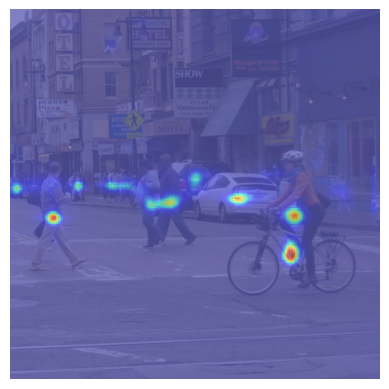

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import cvtColor, resize_image, preprocess_input, get_classes

voc_classes = get_classes("model_data/voc_classes.txt")

img = "img/street.jpg"
try:
    image = Image.open(img)
    converted_image = cvtColor(image)
    image_data = resize_image(converted_image, (input_shape[1], input_shape[0]), False)
    image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)
except:
    print('Open Error! Try again!')
else:
    preds = my_model.predict(image_data)
    image = image.resize((input_shape[0], input_shape[1]))
    plt.imshow(image, alpha=0.5)

    mask        = np.zeros((image.size[1], image.size[0]))
    score       = np.max(preds[0], -1)
    score       = cv2.resize(score, (image.size[0], image.size[1]))
    normed_score    = (score * 255).astype('uint8')
    mask            = np.maximum(mask, normed_score)
        
    plt.imshow(mask, alpha=0.5, interpolation='nearest', cmap="jet")

    plt.axis("off")
    plt.show()